# **Experiment Notebook**



## Context


### 0. Import Packages

In [1]:
! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.1.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
import altair as alt
import gcsfs
import glob
import os
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime
from sklearn.preprocessing import StandardScaler

### 1.   Combine Transactions Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_files = glob.glob('/content/drive/MyDrive/Learning Materials/UTS/Master - Data Science and Innovation/Final Project/Dataset' + "/transactions_*.csv")
all_files

In [7]:
df_list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,  delimiter='|', on_bad_lines='skip')

    base = os.path.basename(filename)  #
    transaction_id = int(base.split('_')[-1].split('.')[0])
    df['transaction_id'] = transaction_id

    df_list.append(df)


df_list = [df.dropna(axis=1, how='all') for df in df_list]

transactions= pd.concat(df_list, axis=0, ignore_index=True)


In [ ]:
df = pd.DataFrame(transactions)
df.to_csv("transactions.csv")

In [ ]:
from google.colab import files
files.download("transactions.csv")

###2. Load The Datasets

In [8]:
tran_url = "https://drive.google.com/file/d/1U1pnms1S-36PdyMZVpUCRsQLJWUqPGzJ/view?usp=sharing"
tran_url = tran_url.split("/")[-2]

!gdown --id {tran_url}

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1U1pnms1S-36PdyMZVpUCRsQLJWUqPGzJ
From (redirected): https://drive.google.com/uc?id=1U1pnms1S-36PdyMZVpUCRsQLJWUqPGzJ&confirm=t&uuid=b7a36a12-db46-4236-a3d4-aee72759b5c4
To: /content/transactions.csv
100% 608M/608M [00:06<00:00, 101MB/s]


In [9]:
cust_url = "https://drive.google.com/file/d/1uARMKvSac6yT0uTbGGvYECI_RtR1NM7g/view?usp=sharing"
cust_url = cust_url.split("/")[-2]
!gdown --id {cust_url}

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uARMKvSac6yT0uTbGGvYECI_RtR1NM7g
To: /content/customers.csv
100% 156k/156k [00:00<00:00, 1.42MB/s]


In [10]:
df_cust = pd.read_csv('customers.csv',delimiter='|')

In [11]:
df_tran = pd.read_csv('transactions.csv')

### 3. Explore & Transform Transactions Dataset

In [12]:
df_tran.head()

,Unnamed: 0,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,transaction_id
0,0,4379006548708470,386831851262,43028f629cc929b691de83bf57e20cd4,1666621971,grocery_pos,13.70,1,Jimenez-Cole,37.466919,-78.238190,126
1,1,4379006548708470,386831851262,00efa3471e368ad849831c94da04d69b,1666622753,gas_transport,267.20,1,"Hansen, Schultz and Jones",36.864743,-79.457201,126
2,2,4379006548708470,386831851262,02fa6cf3372ff1cc1919a41c6c7bb69f,1666747314,shopping_net,784.18,1,"Sanchez, Lopez and Long",37.685351,-78.204569,126
3,3,4379006548708470,386831851262,ec0fbda723956c6dce37bbfabd287cb3,1666755425,misc_pos,7.36,1,"Bauer, Garcia and Frazier",38.394966,-79.976426,126
4,4,4379006548708470,386831851262,111634de854d656d4caf10458f5cf6c3,1666787362,shopping_pos,839.96,1,Johnson-Mendez,38.107685,-79.827665,126


In [13]:
df_tran = df_tran.drop_duplicates()
df_tran = df_tran.dropna(how = 'all')

In [14]:
df_tran = df_tran[df_tran['is_fraud'] == 0]

In [15]:
df_tran_sub = df_tran[['cc_num','unix_time','category','amt']]

In [16]:
df_tran_sub['timestamp'] = pd.to_datetime(df_tran_sub['unix_time'], unit='s')
period_month = df_tran_sub['timestamp'].dt.to_period('M')
start_of_month = period_month.dt.to_timestamp()
end_of_month = start_of_month + pd.offsets.MonthEnd()
df_tran_sub['end_of_month'] = end_of_month.dt.strftime("%Y%m%d").astype(int)

<ipython-input-16-e0d97e581785>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_sub['timestamp'] = pd.to_datetime(df_tran_sub['unix_time'], unit='s')
<ipython-input-16-e0d97e581785>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_sub['end_of_month'] = end_of_month.dt.strftime("%Y%m%d").astype(int)


In [17]:
df_tran_sub['month'] = df_tran_sub['end_of_month'].astype(str).str.slice(-4, -2)

<ipython-input-17-75736c36c3aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_sub['month'] = df_tran_sub['end_of_month'].astype(str).str.slice(-4, -2)


In [18]:
season = {
        ## winter
    '12': 1,
    '01': 1,
    '02': 1,
        ## spring
    '03': 2,
    '04': 2,
    '05': 2,
        ## summer
    '06': 3,
    '07': 3,
    '08': 3,
        ## fall
    '09': 4,
    '10': 4,
    '11': 4
}

df_tran_sub['season'] = df_tran_sub['month'].map(season)

<ipython-input-18-6a983b5fc400>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_sub['season'] = df_tran_sub['month'].map(season)


In [19]:
df_tran_sub

,cc_num,unix_time,category,amt,timestamp,end_of_month,month,season
9,4379006548708470,1646588228,gas_transport,54.85,2022-03-06 17:37:08,20220331,03,2
10,4379006548708470,1648502228,grocery_net,82.09,2022-03-28 21:17:08,20220331,03,2
11,4379006548708470,1647014880,gas_transport,39.83,2022-03-11 16:08:00,20220331,03,2
12,4379006548708470,1648833366,grocery_pos,57.77,2022-04-01 17:16:06,20220430,04,2
13,4379006548708470,1648342413,grocery_net,64.40,2022-03-27 00:53:33,20220331,03,2
...,...,...,...,...,...,...,...,...
4259825,6011969874869415,1661488043,kids_pets,524.40,2022-08-26 04:27:23,20220831,08,3
4259826,6011969874869415,1661228576,kids_pets,475.71,2022-08-23 04:22:56,20220831,08,3
4259827,6011969874869415,1631875114,health_fitness,478.33,2021-09-17 10:38:34,20210930,09,4
4259828,6011969874869415,1644737532,home,560.93,2022-02-13 07:32:12,20220228,02,1


In [20]:
df_tran_sub.drop(columns = ['unix_time', 'timestamp'])

,cc_num,category,amt,end_of_month,month,season
9,4379006548708470,gas_transport,54.85,20220331,03,2
10,4379006548708470,grocery_net,82.09,20220331,03,2
11,4379006548708470,gas_transport,39.83,20220331,03,2
12,4379006548708470,grocery_pos,57.77,20220430,04,2
13,4379006548708470,grocery_net,64.40,20220331,03,2
...,...,...,...,...,...,...
4259825,6011969874869415,kids_pets,524.40,20220831,08,3
4259826,6011969874869415,kids_pets,475.71,20220831,08,3
4259827,6011969874869415,health_fitness,478.33,20210930,09,4
4259828,6011969874869415,home,560.93,20220228,02,1


In [21]:
cats = list(df_tran_sub['category'].unique())

In [22]:
replacements = {
    'gas_transport': 'gas_transport',
    'shopping_net': 'shopping',
    'shopping_pos': 'shopping',
    'misc_net': 'misc',
    'misc_pos': 'misc',
    'grocery_net': 'grocery',
    'grocery_pos': 'grocery',
    'home': 'home',
    'kids_pets': 'kids_pets',
    'personal_care': 'personal_care',
    'food_dining': 'food_dining',
    'health_fitness': 'health_fitness',
    'travel': 'travel',
    'entertainment': 'entertainment'
}

df_tran_sub['category'] = df_tran_sub['category'].map(replacements)

<ipython-input-22-f161c59002c4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_sub['category'] = df_tran_sub['category'].map(replacements)


In [23]:
cats = list(df_tran_sub['category'].unique())
cats_enc = OrdinalEncoder(categories=[cats])

df_tran_sub['cats_enc'] = cats_enc.fit_transform(df_tran_sub[['category']])
df_tran_sub['category'] = df_tran_sub['cats_enc']
df_tran_sub.drop('cats_enc', axis=1, inplace=True)
df_tran_sub['category'].unique()

<ipython-input-23-be4aeb15736b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_sub['cats_enc'] = cats_enc.fit_transform(df_tran_sub[['category']])
<ipython-input-23-be4aeb15736b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_sub['category'] = df_tran_sub['cats_enc']
<ipython-input-23-be4aeb15736b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [24]:
cats = list(df_tran_sub['category'].unique())
cats

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [25]:
aggregated_tran = df_tran_sub.groupby(['cc_num','category', 'end_of_month',	'season']).agg({'amt': 'sum'}).reset_index()

In [26]:
aggregated_tran

,cc_num,category,end_of_month,season,amt
0,60400268763,0.0,20181231,1,5.39
1,60400268763,0.0,20190131,1,3152.91
2,60400268763,0.0,20190228,1,9242.60
3,60400268763,0.0,20190331,2,5701.32
4,60400268763,0.0,20190430,2,6016.01
...,...,...,...,...,...
67945,4986226992066617996,7.0,20220831,3,340.38
67946,4986226992066617996,7.0,20220930,4,4168.69
67947,4986226992066617996,8.0,20221031,4,11452.41
67948,4986226992066617996,9.0,20221231,1,1539.66


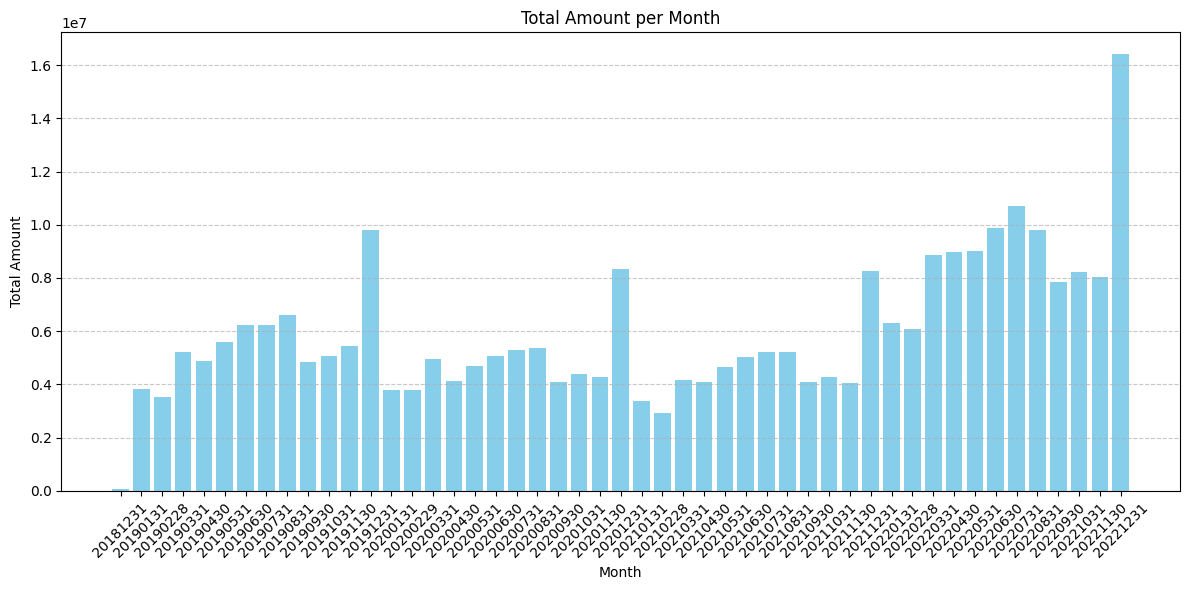

In [27]:
monthly_totals = aggregated_tran.groupby('end_of_month')['amt'].sum().reset_index()
monthly_totals['end_of_month'] = monthly_totals['end_of_month'].astype(str)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_totals['end_of_month'], monthly_totals['amt'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.title('Total Amount per Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

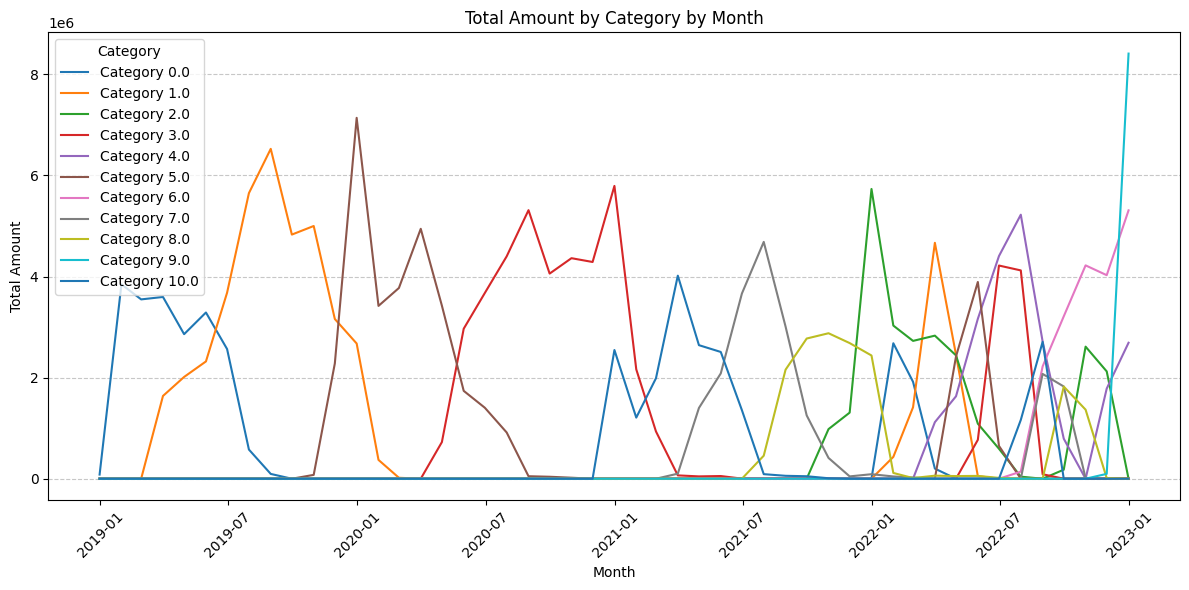

In [28]:
monthly_category_totals = aggregated_tran.groupby(['end_of_month', 'category'])['amt'].sum().reset_index()
monthly_category_totals['end_of_month'] = pd.to_datetime(monthly_category_totals['end_of_month'], format='%Y%m%d')

pivot_table = monthly_category_totals.pivot(index='end_of_month', columns='category', values='amt').fillna(0)

# Plotting the line chart
plt.figure(figsize=(12, 6))
for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], label=f'Category {category}')

plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.title('Total Amount by Category by Month')
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [29]:
aggregated_tran = aggregated_tran[aggregated_tran['end_of_month'] != '20181231']

### 4. Explore & Transform Customer Dataset

In [30]:
df_cust.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787
1,715-55-5575,4351161559407816183,Elaine,Fuller,F,310 Kendra Common Apt. 164,Leland,NC,28451,34.2680,-78.0578,27112,Professor Emeritus,1963-06-07,917558277935
2,167-48-5821,4192832764832,Michael,Cameron,M,05641 Robin Port,Cordova,SC,29039,33.4275,-80.8857,4215,International aid/development worker,1973-05-30,718172762479
3,406-83-7518,4238849696532874,Brandon,Williams,M,26916 Carlson Mountain,Birmingham,AL,35242,33.3813,-86.7046,493806,Seismic interpreter,1942-12-26,947268892251
4,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Fargo,GA,31631,30.7166,-82.5801,559,Medical laboratory scientific officer,1939-05-22,888335239225


In [31]:
df_cust.describe()

,cc_num,zip,lat,long,city_pop,acct_num
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,3.656964e+17,51786.20900,37.422795,-92.505277,2.867058e+05,4.995849e+11
std,1.227337e+18,29933.13195,5.574397,17.510134,5.329632e+05,2.894933e+11
min,6.040027e+10,1571.00000,19.589300,-159.368300,1.050000e+02,2.348758e+09
25%,1.800353e+14,27528.25000,33.712500,-99.159475,2.022950e+04,2.620636e+11
50%,3.517359e+15,49016.00000,38.431750,-87.156600,6.728250e+04,4.915295e+11
75%,4.538733e+15,78599.00000,41.220300,-80.018850,2.499788e+05,7.571575e+11
max,4.986227e+18,99705.00000,64.780500,-68.244800,2.906700e+06,9.993899e+11


In [32]:
df_cust = df_cust.drop_duplicates()
df_cust = df_cust.dropna(how = 'all')

In [33]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ssn       1000 non-null   object 
 1   cc_num    1000 non-null   int64  
 2   first     1000 non-null   object 
 3   last      1000 non-null   object 
 4   gender    1000 non-null   object 
 5   street    1000 non-null   object 
 6   city      1000 non-null   object 
 7   state     1000 non-null   object 
 8   zip       1000 non-null   int64  
 9   lat       1000 non-null   float64
 10  long      1000 non-null   float64
 11  city_pop  1000 non-null   int64  
 12  job       1000 non-null   object 
 13  dob       1000 non-null   object 
 14  acct_num  1000 non-null   int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 117.3+ KB


In [34]:
distinct_counts = df_cust.nunique()
distinct_counts

ssn         1000
cc_num      1000
first        367
last         487
gender         2
street      1000
city         736
state         51
zip          954
lat          952
long         952
city_pop     776
job          507
dob          978
acct_num    1000
dtype: int64

In [35]:
df_cust.loc[:, 'dob2'] = pd.to_datetime(df_cust['dob'])

In [36]:
df_cust['age'] = (datetime.today() - df_cust['dob2']).dt.days/365

In [37]:
df_cust_sub = df_cust[['cc_num','gender','state','city_pop','age']]

In [38]:
gender = list(df_cust_sub['gender'].unique())
gender_enc = OrdinalEncoder(categories=[gender])

df_cust_sub['gender_enc'] = gender_enc.fit_transform(df_cust_sub[['gender']])
df_cust_sub['gender'] = df_cust_sub['gender_enc']
df_cust_sub.drop('gender_enc', axis=1, inplace=True)


<ipython-input-38-ab90db6e068c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust_sub['gender_enc'] = gender_enc.fit_transform(df_cust_sub[['gender']])
<ipython-input-38-ab90db6e068c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust_sub['gender'] = df_cust_sub['gender_enc']
<ipython-input-38-ab90db6e068c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [39]:
state = list(df_cust_sub['state'].unique())
state_enc = OrdinalEncoder(categories=[state])

df_cust_sub['state_enc'] = state_enc.fit_transform(df_cust_sub[['state']])
df_cust_sub['state'] = df_cust_sub['state_enc']
df_cust_sub.drop('state_enc', axis=1, inplace=True)


<ipython-input-39-bb61f7266e56>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust_sub['state_enc'] = state_enc.fit_transform(df_cust_sub[['state']])
<ipython-input-39-bb61f7266e56>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust_sub['state'] = df_cust_sub['state_enc']
<ipython-input-39-bb61f7266e56>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [40]:
df_cust_sub

,cc_num,gender,state,city_pop,age
0,4218196001337,0.0,0.0,32412,64.684932
1,4351161559407816183,1.0,1.0,27112,61.005479
2,4192832764832,0.0,2.0,4215,51.019178
3,4238849696532874,0.0,3.0,493806,81.465753
4,4514627048281480,1.0,4.0,559,85.065753
...,...,...,...,...,...
995,30125158904184,1.0,20.0,990452,30.750685
996,180047909863618,1.0,7.0,27152,42.021918
997,4371450311809,0.0,7.0,171802,25.046575
998,3519925692476886,0.0,12.0,25562,30.268493


### 5. Join the Datasets

In [41]:
df = pd.merge(df_cust_sub, aggregated_tran, on='cc_num', how='inner')

### 6. Split Dataset

In [42]:
X = df[['state', 'age', 'category', 'end_of_month',	'season','city_pop']]
y = df['amt']

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [45]:
X_train_scaled

array([[ 0.60542332, -0.88573856,  0.27715011, -0.79304813, -1.35956207,
        -0.45989737],
       [ 0.25547118,  1.2239118 , -1.40007922, -2.404571  , -1.35956207,
        -0.47322853],
       [ 1.83025582, -0.09243349, -0.05829575,  0.92052034, -0.45924907,
         0.73815429],
       ...,
       [-0.96936132,  0.70819624,  0.27715011, -0.80136107, -1.35956207,
        -0.34685213],
       [ 0.86788743,  0.27305189, -1.06463335, -1.59024215,  0.44106394,
        -0.41713743],
       [ 1.21783957,  1.82513151, -1.40007922, -1.62425734, -0.45924907,
        -0.53403519]])

### 8. Train Machine Learning Model

In [46]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [59]:
model = ExtraTreesRegressor()

param_grid = {
    'min_samples_split': range(1, 5),
    'min_samples_leaf': range(1, 5)
    }

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best parameters: {'min_samples_leaf': 3, 'min_samples_split': 4}


In [47]:
reg1 = ExtraTreesRegressor(criterion= 'squared_error',  min_samples_leaf= 3, min_samples_split= 4)

reg1.fit(X_train_scaled, y_train)

ExtraTreesRegressor(min_samples_leaf=3, min_samples_split=4)

In [48]:
y_train_preds = reg1.predict(X_train_scaled)

In [49]:
print(mean_squared_error(y_train, y_train_preds, squared=False))

2134.164856430613


In [50]:
feature_importances = reg1.feature_importances_

In [51]:
feature_importance_df = pd.DataFrame({
    'Feature': ('state', 'age', 'category', 'end_of_month',	'season','city_pop'),
    'Importance': feature_importances
})
feature_importance_df

,Feature,Importance
0,state,0.108867
1,age,0.325217
2,category,0.172432
3,end_of_month,0.227994
4,season,0.061001
5,city_pop,0.104490


### 9. Assess Model Performance

In [52]:
y_test_preds = reg1.predict(X_test_scaled)
print(mean_squared_error(y_test, y_test_preds, squared=False))

2969.402627816089


In [53]:
y_pred_df = pd.DataFrame(y_test_preds, columns= ['y_pred'])

In [54]:
x_test_df = pd.DataFrame(X_test, columns=['state', 'age', 'category', 'end_of_month',	'season','city_pop']).reset_index(drop=True)
y_test_df = y_test.reset_index(drop=True)
y_pred_df = pd.DataFrame(y_test_preds, columns= ['y_pred']).reset_index(drop=True)

combined_df = pd.concat([x_test_df, y_test_df, y_pred_df], axis=1)

In [55]:
def mse(group):
    return mean_squared_error(group['amt'], group['y_pred'],squared=False)

mse_by_category = combined_df.groupby(['category']).apply(mse).reset_index(name='MSE')

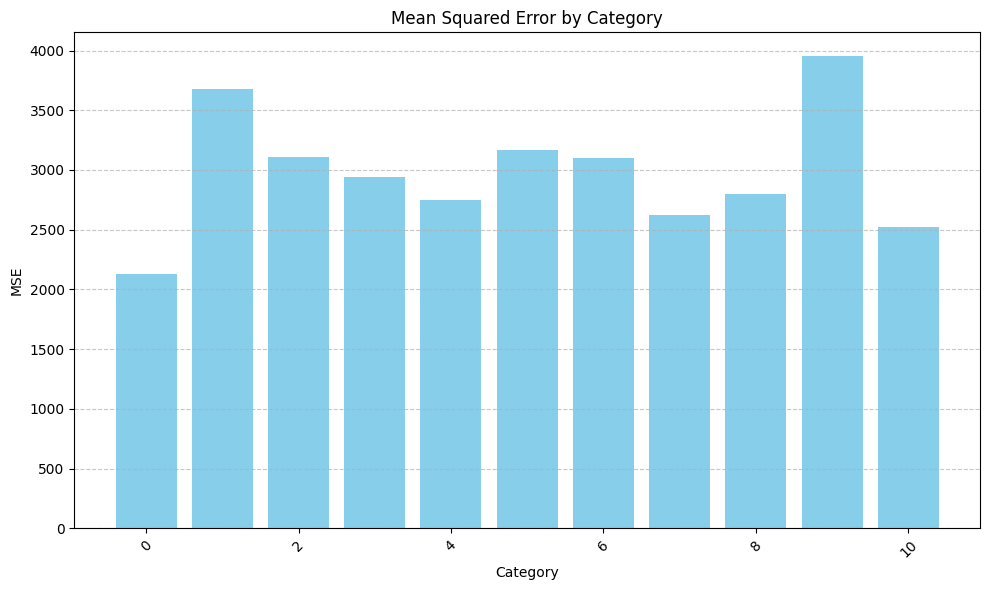

In [56]:
plt.figure(figsize=(10, 6))
plt.bar(mse_by_category['category'], mse_by_category['MSE'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('MSE')
plt.title('Mean Squared Error by Category')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

In [57]:
alt.data_transformers.enable('default', max_rows=None)

perfect_train = alt.Chart(pd.DataFrame({"target": y_train, "preds": y_train})).mark_line(color="green").encode(
    x="target",
    y="preds"
)

pred_chart_train = alt.Chart(pd.DataFrame({"target": y_train, "preds": y_train_preds})).mark_line().encode(
    x="target",
    y="preds"
  )

perfect_train + pred_chart_train

Output hidden; open in https://colab.research.google.com to view.

In [58]:
perfect_test = alt.Chart(pd.DataFrame({"target": y_test, "preds": y_test})).mark_line(color="green").encode(
    x="target",
    y="preds"
)

pred_chart_test = alt.Chart(pd.DataFrame({"target": y_test, "preds": y_test_preds})).mark_line().encode(
    x="target",
    y="preds"
  )

pred_chart_test + perfect_test

alt.LayerChart(...)